In [54]:
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import pathlib


In [55]:

print("OpenCV version:", cv2.__version__)


# Caricare il modello salvato
model = models.resnet18(weights=False)
model = torch.load('C:\\Users\\Chiara Falcone_2\\Desktop\\Computer Vision\\Progetto\\deepfake-generator\\DeepFake_Detection\\df_model.pt')
model = model.to('cuda')
model.eval()


use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model.to(device)
# Trasformazioni per l'immagine
transform = transforms.Compose([
    
    transforms.ToTensor(),
    
])

print(device)


OpenCV version: 4.10.0
cuda


C:\Users\Chiara Falcone_2\AppData\Local\Temp\ipykernel_25008\3438694770.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load('C:\\Users\\Chiara Falcone_2\\

In [56]:

# Caricare e preprocessare l'immagine
image_path = 'C:\\Users\\Chiara Falcone_2\\Desktop\\Computer Vision\\Progetto\\generated_image_337.jpg'
#image_path = 'path_to_image.jpg'
image = Image.open(image_path).convert('RGB')
image_tensor = transform(image).unsqueeze(0)
image_tensor = image_tensor.to(device)




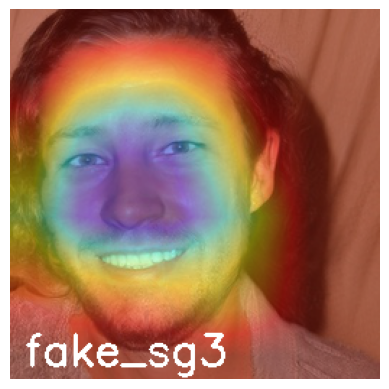

In [57]:
import torch
import torch.nn.functional as F
import numpy as np
import cv2
import matplotlib.pyplot as plt

class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None

        self.target_layer.register_forward_hook(self.save_activation)
        self.target_layer.register_backward_hook(self.save_gradient)

    def save_activation(self, module, input, output):
        self.activations = output

    def save_gradient(self, module, grad_in, grad_out):
        self.gradients = grad_out[0]

    def __call__(self, x):
        self.model.zero_grad()
        output = self.model(x)
        score = output[0].max()
        score.backward(retain_graph=True)
        
        if self.gradients is None or self.activations is None:
            raise ValueError("Gradients or activations are not available. Check the hooks.")

        gradients = self.gradients
        pooled_gradients = torch.mean(gradients, dim=[0, 2, 3], keepdim=True)
        activations = self.activations

        for i in range(len(pooled_gradients)):
            activations[:, i, :, :] *= pooled_gradients[0, i, :, :]

        heatmap = torch.mean(activations, dim=1).squeeze()
        heatmap = np.maximum(heatmap.cpu().detach().numpy(), 0)

        max_val = np.max(heatmap)
        if (max_val > 0):
            heatmap /= max_val
        else:
            heatmap = np.zeros_like(heatmap)

        heatmap = np.clip(heatmap, 0, 1)
        heatmap = np.uint8(255 * heatmap)
        return heatmap, output

def add_label_to_image(image, label):
    font = cv2.FONT_HERSHEY_SIMPLEX
    bottomLeftCornerOfText = (10, image.shape[0] - 10)
    fontScale = 1
    fontColor = (255, 255, 255)
    lineType = 2

    cv2.putText(image, label,
                bottomLeftCornerOfText,
                font,
                fontScale,
                fontColor,
                lineType)
    return image

# Assuming `model` is your pre-trained model and `image_tensor` is the input image tensor
target_layer = model.layer4[1].conv2
grad_cam = GradCAM(model, target_layer)

heatmap, output = grad_cam(image_tensor)

# Get predicted label
predicted_class = torch.argmax(output[0]).item()
class_labels = ['fake_sg3', 'fake_ug', 'real'] # Replace with your class labels
predicted_label = class_labels[predicted_class]

# Convert the original image from tensor to numpy
image = image_tensor.squeeze().permute(1, 2, 0).cpu().detach().numpy()
image = np.uint8(255 * image)

# Resize heatmap to match original image size
heatmap = cv2.resize(heatmap, (image.shape[1], image.shape[0]))

# Apply heatmap on the original image
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
superimposed_img = cv2.addWeighted(heatmap, 0.4, image, 0.6, 0)

# Add the predicted label to the image
labeled_image = add_label_to_image(superimposed_img, predicted_label)

# Display the image
plt.imshow(labeled_image)
plt.axis('off')
plt.show()


### precedente versione

In [58]:
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None

        self.target_layer.register_forward_hook(self.save_activation)
        self.target_layer.register_backward_hook(self.save_gradient)

    def save_activation(self, module, input, output):
        self.activations = output

    def save_gradient(self, module, grad_in, grad_out):
        self.gradients = grad_out[0]

    def __call__(self, x):
        self.model.zero_grad()
        output = self.model(x)
        score = output[0].max()
        score.backward(retain_graph=True)
        

        if self.gradients is None or self.activations is None:
            raise ValueError("Gradients or activations are not available. Check the hooks.")

        gradients = self.gradients
        pooled_gradients = torch.mean(gradients, dim=[0, 2, 3], keepdim=True)
        activations = self.activations

        # Pondera le attivazioni con i gradienti
        for i in range(len(pooled_gradients)):
            activations[:, i, :, :] *= pooled_gradients[0, i, :, :]

        # Calcola la mappa di calore
        heatmap = torch.mean(activations, dim=1).squeeze()
        heatmap = np.maximum(heatmap.cpu().detach().numpy(), 0)

        # Gestione dei valori zero e normalizzazione
        max_val = np.max(heatmap)
        if max_val > 0:
            heatmap /= max_val
        else:
            heatmap = np.zeros_like(heatmap)

        # Converti la heatmap in uint8
        heatmap = np.clip(heatmap, 0, 1)
        heatmap = np.uint8(255 * heatmap)
        return heatmap



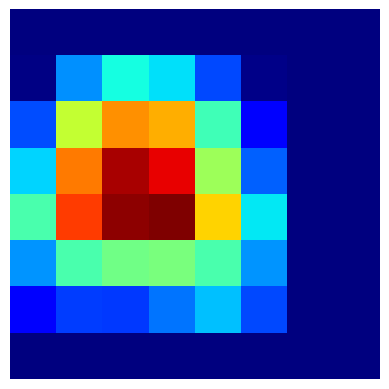

In [59]:
# Verifica la mappa di calore
target_layer = model.layer4[1].conv2

grad_cam = GradCAM(model, target_layer)

heatmap = grad_cam(image_tensor)

plt.imshow(heatmap, cmap='jet')
plt.axis('off')
plt.show()


In [60]:
# Sovrapponi la mappa di calore all'immagine originale
heatmap_resized = cv2.resize(heatmap, (image.size[0], image.size[1]))
print("Heatmap resized shape:", heatmap_resized.shape)

# Controlla l'immagine originale
print("Image shape:", np.array(image).shape)


TypeError: 'int' object is not subscriptable

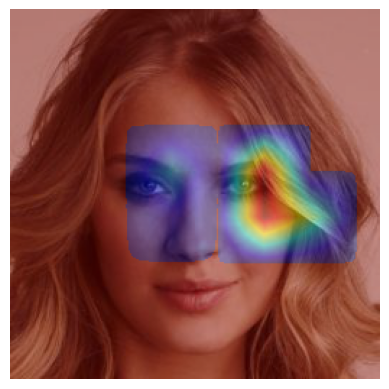

In [ ]:
# Definisci il layer target (l'ultimo strato convoluzionale)
target_layer = model.layer4[1].conv2

# Crea un'istanza di GradCAM
grad_cam = GradCAM(model, target_layer)

# Calcola la mappa di calore
heatmap = grad_cam(image_tensor)

 


# Sovrapponi la mappa di calore all'immagine originale
heatmap = cv2.resize(heatmap, (image.size[0], image.size[1]))
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
superimposed_img = cv2.addWeighted(heatmap, 0.4, np.array(image), 0.6, 1)


# Visualizza l'immagine con la mappa di calore
plt.imshow(superimposed_img)
plt.axis('off')
plt.show()
